<!-- [link text](https://) -->
# **Diffusion Models: Building your own Stable Diffusion**

<img src="https://i.ibb.co/3NgPbzm/diffusion-prac-banner.png" width="100%" />

<a href="https://colab.research.google.com/github/deep-learning-indaba/indaba-pracs-2024/blob/main/practicals/diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

© Deep Learning Indaba 2024. Apache License 2.0.

**Authors:** Sebastian Bodenstein, Kevin Eloff, Amel Sellami

**Reviewers:** Elizaveta Semenova, Redouane Lguensat

**Introduction:**

Denoising Diffusion Models are a variant of generative modelling that serve as the backbone in recent advances in image synthesis - including Dall-E, Stable Diffusion, and Midjourney. These models utilise an iterative denoising process during generation to produce high-quality samples. In this practical, we will explore the fundamentals of diffusion models, the intuition behind them, and how they work in practice. By the end of the practical, we will have covered all the steps required to train one of these models from scratch!


**Topics:**

Content: <font color='blue'>`Generative Models`</font>, <font color='blue'>`Diffusion`</font>.

Level: <font color='yellow'>`Intermediate`</font> to <font color='red'>`Advanced`</font>.

**Aims/Learning Objectives:**

- Fundamentals and intuition behind diffusion models
- Understanding the maths and formulation requirements
- Experience with diffusion model sampling
- How to train diffusion models

**Prerequisites:**

- Familiarity with statistical methods:
    - Multivariate normal distribution
- Familiarity with Python, Numpy and Jax

**Outline:**

>[Diffusion Models: Building your own Stable Diffusion](#scrollTo=_ZefMi2Op8jj)

>>[Installation and Imports](#scrollTo=L2srm6q5p8jk)

>[Diffusion Models: A History](#scrollTo=MFX3d5hu-f7l)

>>[Applications](#scrollTo=DR5alVTk-qiL)

>[Introduction to Image Generation with Diffusion](#scrollTo=GtmZWxNfqQ8L)

>>[1.1 Sampling distributions to generate images](#scrollTo=SnOp4fe5rOkZ)

>>[1.2 Diffusion in practice - Stable Diffusion example](#scrollTo=H2FVAq6yp8jk)

>>>[Important: Only run the code in this subsection (up until 1.3) if you are using Google Colab! Otherwise we recommend just reading through it](#scrollTo=H2FVAq6yp8jk)

>>[1.3 What are denoising diffusion models?](#scrollTo=t2_qL-Nzp8jl)

>>>[Math refresher](#scrollTo=JdoOYSZPp8j0)

>>[1.4 Requirements for Diffusion](#scrollTo=LfdgfYdBp8j0)

>>[1.4.1 Diffusion noise schedule](#scrollTo=9TBGnHI8p8j1)

>>>[Math Refresher](#scrollTo=h23CB2sf_6Co)

>>[1.5 Forward Diffusion](#scrollTo=EYHjneYPJNEy)

>>>[Math behind forward diffusion (Optional)](#scrollTo=M-JDHCCBMCq4)

>>>[Example of forward diffusion applied to an image](#scrollTo=9ec_7WSZKNAU)

>>>[Math behind forward diffusion continued (Optional)](#scrollTo=fbuNQbtzMYmF)

>>[1.6 Reverse Diffusion](#scrollTo=upAHpuGxp8j2)

>>>[Math intro to reverse diffusion (optional)](#scrollTo=wzhGWWAVN0TR)

>>>[Reverse diffusion in practice](#scrollTo=v9-b-qZSPI75)

>>[1.7 Augmenting the reverse process with a model](#scrollTo=hr8Tq9sup8j3)

>[Training and Sampling (generating images)](#scrollTo=RLeHee8ep8j3)

>>[2.1. Putting it all together](#scrollTo=uQUXl-64p8j3)

>>>[Training](#scrollTo=eRXmcUJcp8j3)

>>>[Generation and sampling](#scrollTo=iydKOuAmp8j7)

>>[2.2 Diffusion in one dimension](#scrollTo=xtxUZBpC5yBq)

>>[2.3 Training a model](#scrollTo=A47aGk11goW2)

>[Conclusion](#scrollTo=U1Z1me6sp8kG)

>>[Feedback](#scrollTo=Ol-0Ae-7p8kG)



**Before you start:**

For this practical, you will need to use a GPU if you are on Google Colab to generate images. To do this, go to the "Runtime" menu in Colab, select "Change runtime type" and then in the popup menu, choose "GPU" in the "Hardware accelerator" box.

Another important step you need to do. You cannot continue without this!
- Go to `Tools > Settings > Miscellaneous`
- Make sure the options for `Kitty mode` and `Corgi mode` are checked!

**Suggested experience level in this topic:**

| Level         | Experience                            |
| --- | --- |
`Beginner`      | It is my first time being introduced to this work. |
`Intermediate`  | I have done some basic courses/intros on this topic. |
`Advanced`      | I work in this area/topic daily. |

In [ ]:
# @title **Paths to follow:** What is your level of experience in the topics presented in this notebook? (Run Cell)
experience = "advanced" #@param ["beginner", "intermediate", "advanced"]

if experience == "beginner":
    print("""
    Based on your experience, we advise:
    - Skip the coding tasks, rather focus on your understanding
    - Rather run the cells and play with the outputs.

    In terms of content, we suggest you focus on Section 1.1, 1.5, 2.1, and 2.4!
    """)
elif experience == "intermediate":
    print("""
    Based on your experience, we advise:
    - Try out the coding tasks, and try get a high-level understanding of the maths

    In terms of content, we suggest you focus on Section 1.1, 1.5, 2.1, and 2.4!
    """)
elif experience == "advanced":
    print("""
    Based on your experience, we advise going through the whole notebook in detail.

    Feel free to play with the code and come up with your own implementations!
    """)

print("\nNote: This is just a guideline!")

## Installation and Imports

In [ ]:
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)
%%capture
# !pip install jax==0.3.25 jaxlib==0.3.25 flax transformers ftfy

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
import requests
import torch
import seaborn

In [ ]:
# @title Helper Functions. (Run Cell)

def extract(a, t, x_shape):
    batch_size = x_shape[0]
    out = a[..., t]
    return jnp.reshape(out, (batch_size, *((1,) * (len(x_shape) - 1))))

def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

# Diffusion Models: A History
Diffusion models in deep learning generate data (similar to the training data) by iteratively adding and reversing noise.

Diffusion is based on the process of particles spreading out.
Like the spreading of particles in a fluid, diffusion models gradually distribute information.

Diffusion has been explored as an alternative to [GANs](https://www.deeplearningbook.org/contents/generative_models.html) or [VAEs](https://www.deeplearningbook.org/contents/autoencoders.html) models.

Diffusion models have evolved significantly from their traditional roots in image processing, where they were primarily employed for tasks like noise reduction and image restoration. These early methods relied on hand-crafted mathematical models to describe the diffusion process. However, the advent of deep learning marked a transformative shift. By leveraging neural networks, diffusion models can now learn the intricacies of the diffusion process directly from data, unlocking their potential for a vast array of applications, particularly in the generative modeling domain.

## Applications

***Image Synthesis and Restoration***
* Diffusion models can be employed to generate high-quality images. Starting from random noise, the diffusion process gradually refines this noise over several steps to produce an image resembling those in the training dataset.
* Super-Resolution: These models can enhance the resolution of images, taking a low-res image and iteratively refining it to produce a higher-resolution version.
* Image Inpainting: If an image has missing parts or unwanted obstructions, diffusion models can be used to fill in or ‘inpaint’ these gaps by iteratively refining the incomplete image until it appears whole.
* Denoising: As the name suggests, one of the fundamental uses of diffusion models is to remove noise from images, enhancing their quality.

***Generation of Content: Text, Sounds, etc.***
* Text Generation: While images are a common application, diffusion models can also be adapted for text. They can generate coherent and contextually relevant text over iterative refinement stages.
* Sound Synthesis: Diffusion models have the potential to be used in generating or enhancing audio content. Starting with noise or a basic melody, the model can refine the audio over several steps to produce a richer sound.
* Video Synthesis: By applying diffusion principles frame-by-frame, these models can aid in generating or enhancing video content.

***Other Applications***
* Drug Discovery: In bioinformatics, diffusion models can be utilized to explore the vast space of molecular structures, iteratively refining candidate molecules for potential therapeutic use.
* Anomaly Detection: By learning the diffusion process of ‘normal’ data, these models can identify data points that do not follow the expected diffusion pattern, flagging them as anomalies.


# 1. Introduction to Image Generation with Diffusion

## 1.1 Sampling distributions to generate images
Digital images on computers are generally defined by three color channels: <font color='red'>red</font>, <font color='lime'>green</font>, and <font color='blue'>blue</font> (RGB). These are the primary colors used to represent images in digital format. Each pixel in an image is composed of three values corresponding to the Red, Green, and Blue channels. By combining different intensities of these three colors, a wide spectrum of colors can be created.
In our setup, the color intensities will range from 0 to 1, with 1 being most intense and 0 being least intense.

If we want to generate an image through sampling, what we typically mean is that we want to sample these three RGB color channels for every pixel in a smart way that results in some image e.g. a cat. But what does it mean to sample these colors?

Let us start by sampling some pixel colors from Gaussian distributions defining seperately each of the three RGB channels. Play around with the mean and standard deviation for each color to visualise how the distribution changes!

_Note: We apply a modulus operation to ensure values remain between 0 and 1. This might cause a bimodal distribution if your means are close to 0 or 1! Alternatively a clipping operation may be used._

In [ ]:
#@title Visualise colour distributions (Run Cell) { run: "auto" }

np.random.seed(42)

resolution = 0.025
bins = np.arange(0, 1 + resolution, resolution)

red_mean = 0.6 #@param {type:"slider", min:0, max:1, step:0.05}
red_std = 0.1 #@param {type:"slider", min:0.05, max:1, step:0.05}

green_mean = 0.3 #@param {type:"slider", min:0, max:1, step:0.05}
green_std = 0.2 #@param {type:"slider", min:0.05, max:1, step:0.05}

blue_mean = 0.75 #@param {type:"slider", min:0, max:1, step:0.05}
blue_std = 0.1 #@param {type:"slider", min:0.05, max:1, step:0.05}

r = np.random.normal(red_mean, red_std, size=(100000,))%1
# density, _, _ = plt.hist(r, bins=bins, density=True, alpha=0.3, color='red');
# plt.plot(bins[:-1]+resolution/2, density, color='red')
seaborn.histplot(r, bins=bins, kde=True, color='red', stat="density", alpha=0.3, linewidth=0)

g = np.random.normal(green_mean, green_std, size=(100000,))%1
# density, _, _ = plt.hist(g, bins=bins, density=True, alpha=0.3, color='green');
# plt.plot(bins[:-1]+resolution/2, density, color='green')
seaborn.histplot(g, bins=bins, kde=True, color='green', stat="density", alpha=0.3, linewidth=0)

b = np.random.normal(blue_mean, blue_std, size=(100000,))%1
# density, _, _ = plt.hist(b, bins=bins, density=True, alpha=0.3, color='blue');
# plt.plot(bins[:-1]+resolution/2, density, color='blue')
seaborn.histplot(b, bins=bins, kde=True, color='blue', stat="density", alpha=0.3, linewidth=0)
plt.xlabel("Color intensity")
plt.ylabel("Distribution")
plt.xlim(0,1)
plt.grid()

Now that the distributions of the three colors have been defined, we can plot a few samples:

In [ ]:
#@title Plot samples from the distributions above (Run Cell)

import matplotlib.pyplot as plt
import numpy as np

def generate_color_samples(num_samples=12):
  fig, axes = plt.subplots(2, 6, figsize=(12, 4))
  axes = axes.flatten()

  for i in range(num_samples):
    r = np.random.normal(red_mean, red_std)%1
    g = np.random.normal(green_mean, green_std)%1
    b = np.random.normal(blue_mean, blue_std)%1

    color_array = np.ones((100, 100, 3))
    color_array[:, :, 0] = r
    color_array[:, :, 1] = g
    color_array[:, :, 2] = b

    axes[i].imshow(color_array)
    axes[i].axis('off')
    axes[i].set_title(f"r={r:.1f}, g={g:.1f}, b={b:.1f}")

  plt.tight_layout()
  plt.show()

generate_color_samples()


We are able to sample colours given a random variable defining colour intensities for red, green and blue!

What if we tried to use this to generate an entire image? To do this we sample a lot of pixels at once (32x32) and plot them as an image using `plt.imshow()`

In [ ]:
red = np.random.normal(red_mean, red_std, size=(32,32))%1
green = np.random.normal(green_mean, green_std, size=(32,32))%1
blue = np.random.normal(blue_mean, blue_std, size=(32,32))%1

image = np.stack([red, green, blue], axis=2)
plt.imshow(image);

As expected, there is just a whole lot of random pixel colours. We can't really make out any shape or object within the image.

What if we did want to sample something coherent, like an image of a cat or a dog? How do we sample pixel values in such a way that we're able to generate a proper image? How would we even define such a distribution?

A naive approach would be using a simple linear neural network to predict the mean and variance of a Gaussian distribution for each pixel, but this would quickly converge on predicting the mean and variance of the entire dataset. While the rough shape might be there, it will likely be blurry and hard to make out.

**Group task:** Consider that you've trained a predictive model using pixel-wise MSE loss, where the model is composed of a mixture as described above. Why do you think this model is prone to collapsing into predicting only the mean and variance of the training set?

This is where the field of generative modelling comes into play. We need to define a way of sampling pixels that is dependent on the other pixels in the image. Diffusion offers an intuitive way of performing such sampling.

## 1.2 Diffusion in practice - Stable Diffusion example

### <font color="red">Important: Only run the code in this subsection (up until 1.3) if you are using Google Colab! Otherwise we recommend just reading through it</font>

To start things off, we're going to take a look at a pre-trained image generation model. The goal here is simply to witness the incredible power and capabilities of these models. For this, we will be using StabilityAI's [Stable Diffusion](https://stability.ai/blog/stable-diffusion-public-release), made available on the HuggingFace diffusers library. You're also welcome to try other HuggingFace Diffuser models, go take a look [here](https://huggingface.co/docs/diffusers/index) for more info!

Reminder: It is important that you use a GPU Colab runtime for this! `Edit > Notebook settings > Hardware accelerator > GPU`

This cell can take a minute or two to run, as it downloads the various model checkpoints. Comment out `%%capture` if you would like to see the download progress.

In [ ]:
## Install diffusers on Colab (Run cell)
%%capture
!pip install diffusers
!pip install invisible_watermark transformers accelerate safetensors

In [ ]:
%%capture
from diffusers import DiffusionPipeline

# download and load a Stable Diffusion checkpoint
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

Now to generate an image! Feel free to modify the prompt to anything you'd like!

Example prompts:
- "A giant baobab tree, in the style of Starry Night painted by Van Gogh"
- "An astronaut riding a lion on Mars"
- "Baobab tree logo"

In [ ]:
prompt = "Create an image of a Senegalese sunrise with a fisherman in a traditional pirogue on a calm river, a towering baobab tree in the background, and the warm colors of the morning sky. Incorporate subtle hints of Senegal's national colors—green, yellow, and red—into the landscape."
image = pipe(prompt=prompt).images[0]
image

Now isn't that cool? We were able to take a text prompt and produce a completely new image!

**Group task**
- What sort of cool images can you come up with?
- Stable Diffusion is trained on a lot of images, do you think you could come up with an image that wouldn't be in the training set? How would the model perform?
  - We are not exactly sure what the model has or has not seen, we just know it is many terabytes of images sourced from the internet. This includes public domain images, licensed datasets, and images uploaded by users on various platforms.

**Cleaning up...**

When you're ready to move on, run the cell below. The Stable Diffusion model is quite large (~13GB) and uses up all of our available GPU memory... To continue the practical we will first unload the model and clear our GPU memory. Run the cell below.

In [ ]:
# @title Run this to clear GPU memory. (Run Cell)
import time
del pipe
del prompt
image_temp = np.asarray(image).copy()
del image
torch.cuda.empty_cache()
time.sleep(2) # torch takes time to remove the variables!
torch.cuda.empty_cache()
image = Image.fromarray(image_temp)

<font color='red'>**Warning!** if this step failed, you will run out of memory when you do jax operations later! Check if your **GPU VRAM** has reset in the top right resources tab.</font>

## 1.3 What are denoising diffusion models?

Now that we have seen the power of diffusion models, how do they work and how can we make them ourselves?

Denoising Diffusion Models (DDMs), commonly referred to as Diffusion, is a variant of generative modelling. The goal of a generative model is to create new instances of something after being given sufficiently many examples. Ideally, we also want these models to generalise. For example, if I have two separate images of a `lion` and an `astronaut`, can I create a novel image containing both? Or if I've seen a painting by Vincent Van Gogh, could I make a new image of a Baobab tree in the same style?

Diffusion is the process of iteratively denoising (or refining) a sample starting from random noise. The goal is to generate a novel sample that isn't present in our training data.

From this point forward, we will consider diffusion in the context of images, although diffusion could theoretically be applied to many more domains!
A diffusion probabilistic model (which we will call a “diffusion model” for brevity) is a parameterized Markov chain trained using variational inference to produce samples matching the data after finite time.

To do this, we define two diffusion process:
- **Forward diffusion**\
  The process of adding noise to an image.\
  We can define this as the distribution $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$ where $\mathbf{x}_t$ is a slightly noiser version than the image $\mathbf{x}_{t-1}$.
- **Reverse diffusion**\
  The process of removing noise from an image by moving towards some reference.\
  We can define this as the distribution $q(\mathbf{x}_{t-1}|\mathbf{x}_t,\mathbf{x}_0)$ where $\mathbf{x}_0$ is the ground truth image. Here $\mathbf{x}_{t-1}$ has less noise than $\mathbf{x}_{t}$ and is closer to the target $\mathbf{x}_0$.

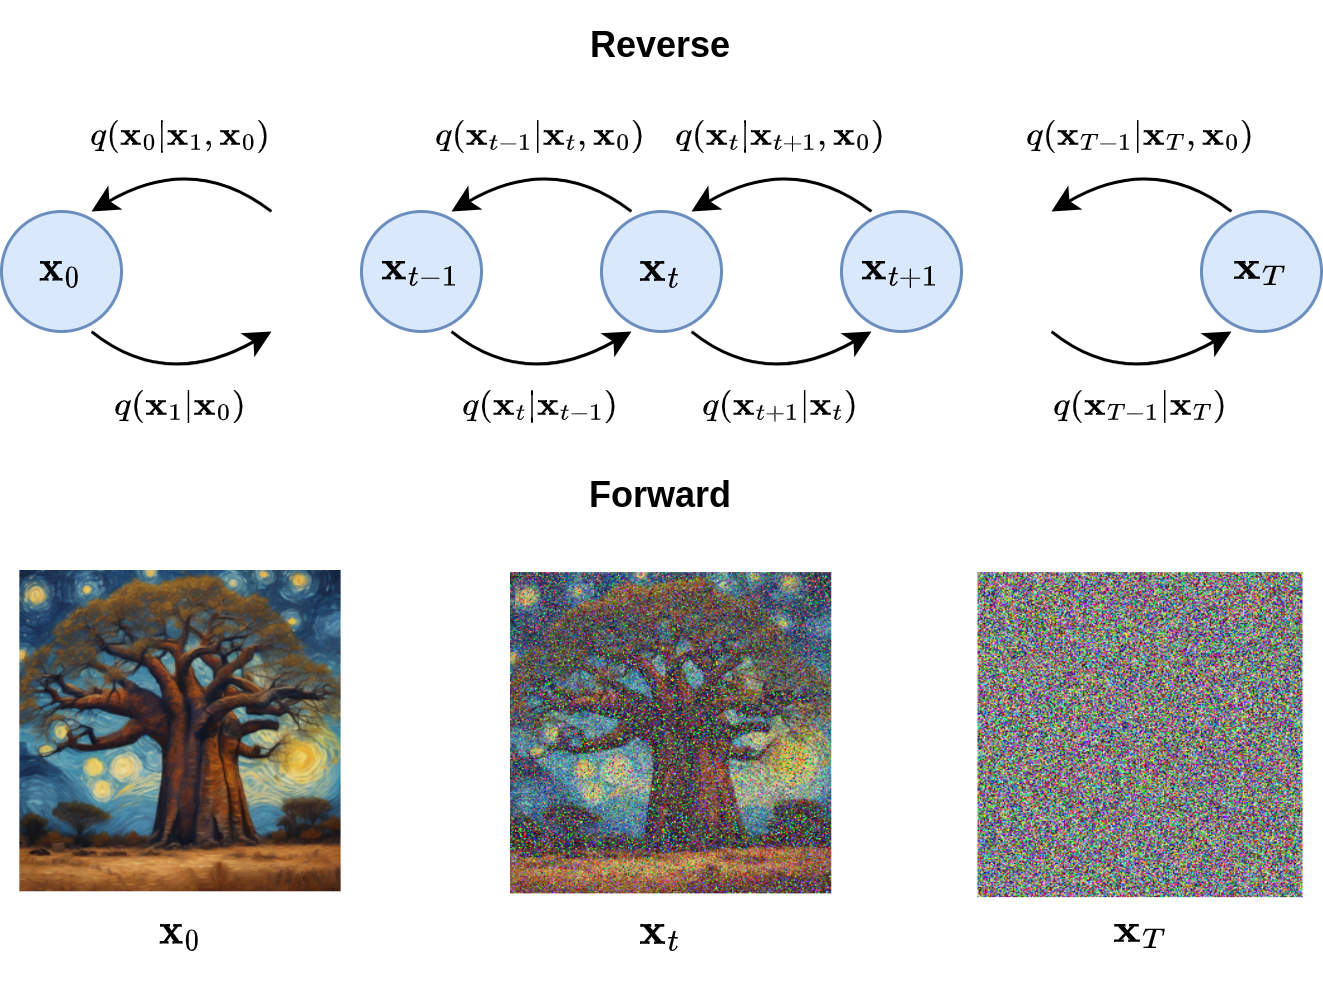

Let us set some terminology for the equations moving forward:

- $\mathbf{x}_0$ is the ground truth image
- $\mathbf{x}_t$ is an image noised by $t$ steps
- $T$ is the maximum number of noising steps
  - $T$ is a hyperparameter, and may be chosen. In this prac we will set $T=300$


### Math refresher
What is the ' $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$' in the above equation ?

* The bar we often see in the middle of probability distribution notation is used to separate the random variables of the distribution from the variables that the random variables are conditioned on.
* In other words, we have a function with two different kinds of inputs. The inputs on the right of are conditioning variables. The inputs on the left of
 are the values of the random variables under the probability distribution. The output of the function is the probability of the values of these random variables.
We read as 'the probability of $\mathbf{x}_t$ given  $\mathbf{x}_{t-1}$'.


## 1.4 Requirements for Diffusion

The intuition behind Diffusion models is not limited to images. It can actually be applied to other domains. In general, if you can meet these requirements you should be able to apply Diffusion:

1. We must be able to “**undo**” the forward noising process.
  - Given a target $\mathbf{x}_0$, you must be able to reverse the noising process and eventually reconstruct $\mathbf{x}_0$.
  - This process must happen in small increments.
2. At time-step $T$, the data should be **random noise**.
  - After iteratively adding noise for $T$ steps, the result should be something independent of the starting point $\mathbf{x}_0$.
  - This means that (theoretically) any $\mathbf{x}_0$ can become any $\mathbf{x}_T$ with the forward process, and any $\mathbf{x}_T$ can become any $\mathbf{x}_0$ with the reverse process.


## 1.4.1 Diffusion noise schedule

Before moving on to defining the forward and reverse processes, we first need to define a noise schedule. This is used to schedule how much noise we add at each timestep $t$. For low values of $t$, we only want to add/remove a small amount of noise with the diffusion functions, while at later time-steps we want to add significantly more.

Thus, we define our noise schedule $\{\alpha_t\}_{t=1}^T$ as monotonically decreasing scalar for each time-step $t$ ranging from 1 to 0. We also define $\beta_t = 1 - \alpha_t$. Typically, $\alpha_t$ would use either a linear or cosine decay. The authors of the [Denoising Diffusion Probabilistic Models paper](https://arxiv.org/pdf/2006.11239.pdf), chose a simple linear schedule going from $\beta_1 = 1\times10^{-4}$ to $\beta_T = 0.02$.

Note: This noise schedule is considered a hyperparameter, and is fixed for the rest of the practical!

**Code task:** implement this linear decay for $\alpha$ using `jax.numpy`.

_hint: look at the documentation for `jnp.linspace`_

In [ ]:
def linear_alpha_schedule(timesteps):
    alpha_start = 0.9999
    alpha_end = 0.98
    return ... # YOUR CODE GOES HERE

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def linear_alpha_schedule(timesteps):
    alpha_start = 0.9999
    alpha_end = 0.98
    return jnp.linspace(alpha_start, alpha_end, timesteps)

In [ ]:
# We can choose this hyperparameter, but 200 seems to be the most common!
T = 200

# Define alpha schedule.
alphas = linear_alpha_schedule(timesteps=T)
betas = 1 - alphas

# Define alpha bar (alpha_cumprod), sqrt alpha bar, and sqrt(1 - alpha bar)
# These will come in handy later!
alphas_cumprod = jnp.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = jnp.sqrt(1.0 - alphas_cumprod)

In [ ]:
# @title Plot beta schedule (Run Cell)
fig, ax_a = plt.subplots()

ax_a.plot(alphas)
ax_a.set_xlabel("$t$", fontsize=16)
ax_a.set_ylabel(r'$\alpha$', fontsize=16)
ax_a.grid()

ax_b = ax_a.twinx()
ax_b.plot(betas, c='tab:orange')
ax_b.set_ylabel(r'$\beta$', fontsize=16)
ax_a.legend([r'$\alpha$'], bbox_to_anchor =(0.35,-0.3), loc='lower center', fontsize=16)
ax_b.legend([r'$\beta$'], bbox_to_anchor =(0.65,-0.3), loc='lower center', fontsize=16)
plt.show();

### Math Refresher

The normal – also known as Gaussian – distribution is one of the most common distributions for modeling *continuous* random variables, i.e., corresponding to events with an uncountable number of outcomes. Its probability density function is
$$
p(X = x) = \mathcal{N}(x\mid \mu, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right),
$$
where $\mu$ and $\sigma$ are the *mean* and *standard deviation* (also called the location, and scale or square-root of the *variance* $\sigma^2$, respectively).


## 1.5 Forward Diffusion

Let's now take a closer look at the forward diffusion process. Recall that in this process, we want to define the process of iteratively corrupting or noising an image. To do this, we define the distribution $q(\mathbf{x}_{t}|\mathbf{x}_{t-1})$. Given the image at $t-1$, we predict a slightly corrupted version for the next time-step $t$.

For images, we can define this **forward** noising distribution as a Gaussian parameterized distribution.

*Why is it defined as a Gaussian:*
* *Gaussian distributions are well-understood and have closed-form expressions for probability density functions, cumulative distribution functions, and moments. This makes calculations and derivations significantly easier.*
* *Isotropy: Gaussian noise is isotropic, meaning it has the same properties in all directions. This is crucial for diffusion models as it ensures that the noise is added uniformly to the data, preventing bias in any particular direction.*
* *Central Limit Theorem: The Central Limit Theorem states that the sum of independent random variables tends to follow a normal (Gaussian) distribution. This property makes Gaussian noise a natural choice for modeling random perturbations.*
* *Smoothness: Gaussian noise is smooth, which can help preserve the underlying structure of the data during the diffusion process.*

The **forward** noising distribution is defined as follows:

$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathscr{N}(\mathbf{x}_t ; \sqrt{\alpha_t}\mathbf{x}_{t-1},(1-\alpha_t)\mathbf{I})
$$

where $\mu = \sqrt{\alpha_t}\mathbf{x}_{t-1}$ is the mean, and $\sigma^2 = (1-\alpha_t)\mathbf{I}$ is the variance.
We can also sample $\mathbf{x}_t \sim q(\mathbf{x}_t|\mathbf{x}_0)$ directly given $\mathbf{x}_0$; see [Luo C](https://arxiv.org/pdf/2208.11970.pdf) for the derivation.

$$
q(\mathbf{x}_t|\mathbf{x}_0) = \mathscr{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t}\mathbf{x}_0,(1-\bar{\alpha}_t)\mathbf{I})
$$

where $\bar{\alpha}_t = \prod^t_{\tau=1}\alpha_\tau$. This will be useful during training as it would be more efficient to directly sample $\mathbf{x}_t$ given $\mathbf{x}_0$.


**Code task:** implement the forward diffusion equation $q(\mathbf{x}_t | \mathbf{x}_{t-1})$

_hint: a property of normal distribution allows us to add the mean and multiply by the variance. In this code task, we want to write the code to sample the equations listed above._

In [ ]:
# Forward diffusion - q(x_t|x_tm1):
def q_sample_one_timestep(x_tm1, t, noise):
    # `noise` is a normal distribution with mean 0 and variance 1

    # Make sure alpha is the correct shape, and allow for batching
    alpha_t = extract(alphas, t, x_tm1.shape)

    return ... # YOUR CODE GOES HERE

# Forward diffusion from x_0 - q(x_t|x_0):
def q_sample(x_start, t, noise):
    # `noise` is a gaussian random normal with mean 0 and variance 1

    # Make sure alpha is the correct shape
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return ... # YOUR CODE GOES HERE

In [ ]:
# @title Answer to code task (Try not to peek until you've given it a good try!')
def q_sample_one_timestep(x_tm1, t, noise):
    # `noise` is a gaussian random normal with mean 0 and variance 1

    # Make sure alpha is the correct shape
    alpha_t = extract(alphas, t, x_tm1.shape)

    return jnp.sqrt(alpha_t) * x_tm1 + (1 - alpha_t) * noise

# Forward diffusion - q(x_t|x_0):
def q_sample(x_start, t, noise):
    # `noise` is a gaussian random normal with mean 0 and variance 1

    # Make sure alpha is the correct shape
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

### Math behind forward diffusion (Optional)

We have included a section here including some of the math behind the forward process, along with some refreshers like Expectation. This section is optional if you want a deeper dive into the math!

**Expectation**

The expected value of a random variable is the value that we expect to get on average when we sample a large number of different outcomes from the random event.

For example, if we consider the example of flipping a coin, where $X = 1$ if the coin lands on heads and $X = 0$ if the coin lands on tails, then intuitively the expected value is $0.5$. To see this, think about a game where you get 1 coin for heads and no coins for tails. If you play a thousand games, you should expect to get about $500$ coins in total. So your expected profit from a single match is $500/1000 = 0.5$ coins.

More precisely, we can write the expected value as
$$
\mathbb{E}[X] = \sum_x x \cdot p(X=x),
$$
for a discrete random variable $X$ or
$$
\mathbb{E}[X] = \int x \cdot p(X=x) \, \mathrm{d}x,
$$
for a continuous random variable. From this definition, we can think of the expected value as a weighted average of all the values of $X$, where the weighting for each value is the probability of observing it.

**Diffusion Math**

For many modalities, we can think of the data we observe as represented or generated by an associated unseen latent variable, which we can denote by the random variable $z$.

The objects we encounter in the actual world may be generated as a function of some higher-level representation. What we observe can be interpreted as a three-dimensional projection; similarly, **we can approximate latent representations that describe the data we observe**.

In general, we seek to learn lower-dimensional latent representations rather than higher-dimensional ones. This is because trying to learn a representation of higher dimension than the observation is a fruitless endeavor without strong priors. On the other hand, learning lower-dimensional latents can also be seen as a form of compression, and can potentially uncover semantically meaningful structures describing observations.

**Evidence Lower Bound**

In math, we can imagine the latent variables and the data we observe as modeled by a joint distribution $p(x, z)$.

**One approach to generative modeling, termed "likelihood-based," is to learn a model to maximize the likelihood $p(x)$ of all observed $x$.**

We need the likelihood $p(x)$. How would we recover this from the joint distribution $p(x, z)$?

One solution is to explicitly marginalize (integrate out) the latent variable $z$.
\begin{align}
        p(x)= &\int p(x,z) \, \mathrm{d}z \\[1em]
\end{align}

or apply the [chain rule](https://en.wikipedia.org/wiki/Chain_rule_(probability)):

\begin{align}
        p(x) = \frac{p(x,z)}{p(z \mid x)}
\end{align}

Using the first equation might be hard as integrating out all latent variables $z$ can be intractable for complex models. It can also mean that we need the ground truth latent encoder:
\begin{align}
        p(z \mid x)
\end{align}

We can derive a term from both equations named the Evidence Lower Bound (ELBO), which is a lower bound for the evidence. The evidence is quantified in this case as the log-likelihood of the observed data.

The **log-likelihood** is used for several reasons:
* **Preventing underflow:** Probabilities are often very small numbers. Multiplying many small numbers together can lead to underflow (values too small to be represented by a computer), which can cause computational issues.
* **Relation to information theory:** The negative log-likelihood is closely related to information theory concepts like entropy and Kullback-Leibler divergence.
* **Convexity:** In many cases, the log-likelihood function is concave (or convex downwards), making it easier to find its maximum using optimization algorithms.

The **ELBO** is defined as follows:

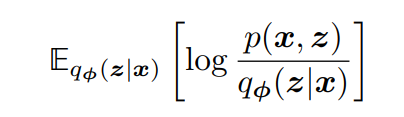

The relationship with the evidence is as follows:

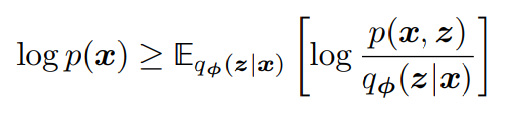

with:
\begin{align}
{q_{ᶿ}(z \mid x)},
    \end{align}
  is a an approximate variational distribution with paramter with Θ to optimize. But how do we get the inequation?
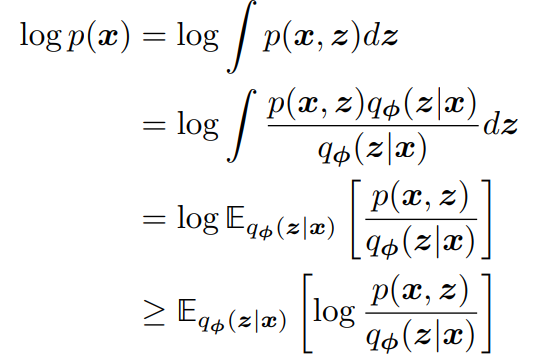

Let's expalin the math above:

* First, let's introduce the log to the evidence as explained above.
* Multiply by the 'q' distribution above and below (1=x/x)
* The third line is the definition of expectation
* All you need to pass to the inequlity is by applying the jensen's inequality.

But the above proof gives no intuition on exactly why the ELBO is actually a lower bound of the evidence


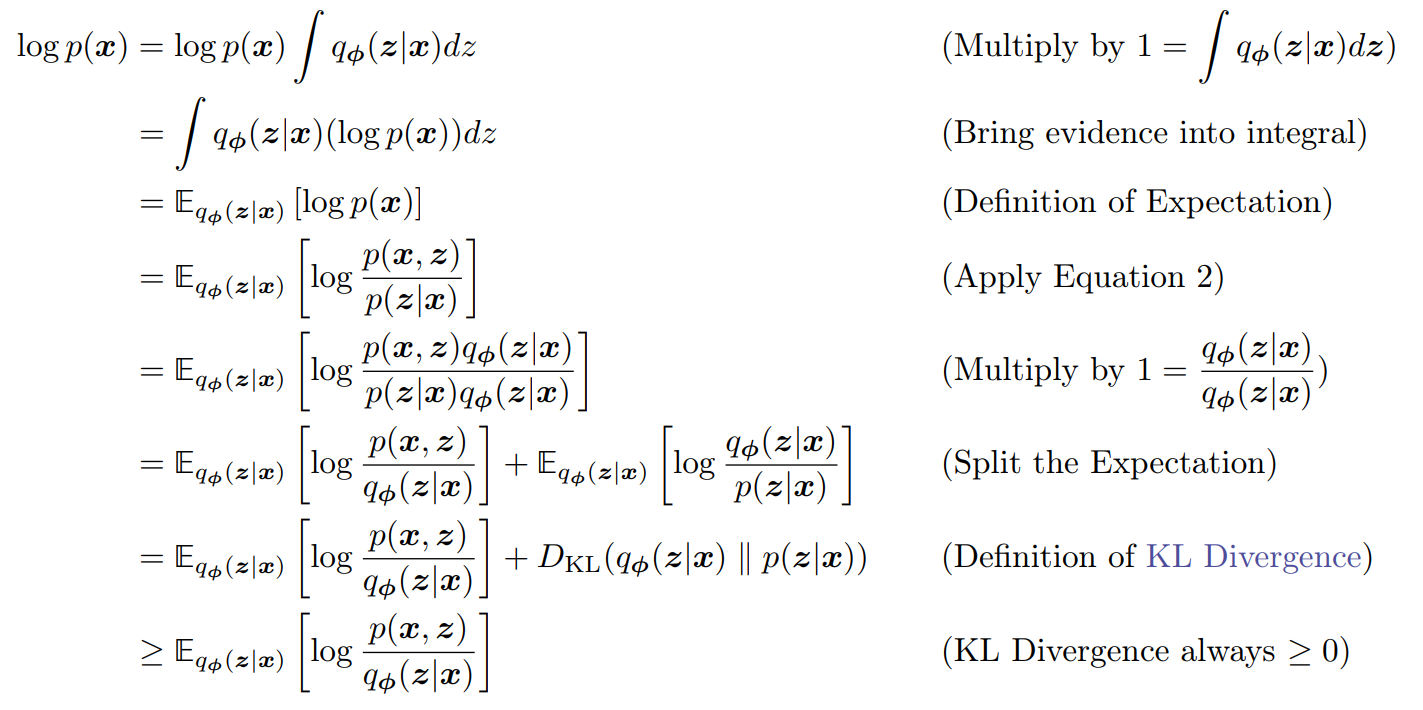

We now know why the ELBO is indeed a lower bound: the difference between the evidence and the ELBO is a strictly non-negative KL term, thus the value of the ELBO can never exceed the evidence.
Secondly, we explore why we seek to maximize the ELBO. Having introduced latent variables $z$ that we would like to model, our goal is to learn this underlying latent structure that describes our observed data. In other words, we want to optimize the parameters of our variational posterior $q_\phi(z \mid x)$ to exactly match the true posterior distribution $p(z \mid x)$, which is achieved by minimizing their KL Divergence (ideally to zero).

It's intractable to minimize this KL Divergence term directly, as we do not have access to the ground truth $p(z \mid x)$ distribution.

However, notice that on the left-hand side of Equation 15, the likelihood of our data (and therefore our evidence term $\log p(x)$) is always a constant with respect to $\phi$, as it is computed by marginalizing out all latents $z$ from the joint distribution $p(x, z)$ and does not depend on $\phi$ whatsoever. Since the ELBO and KL Divergence terms sum up to a constant, any maximization of the ELBO term with respect to $\phi$ necessarily invokes an equal minimization of the KL Divergence term. Thus, the ELBO can be maximized as a proxy for learning how to perfectly model the true latent posterior distribution; the more we optimize the ELBO, the closer our approximate posterior gets to the true posterior. Additionally, once trained, the ELBO can be used to estimate the likelihood of observed or generated data as well, since it is learned to approximate the model evidence $\log p(x)$.


But why the ELBO?
ELBO is a fundamental concept in variational inference.
Diffusion models and VAEs involve latent variables and inferring information about them.

* **Latent Variables:** In VAEs, latent variables represent a compressed code of the input data. In diffusion models, the noise levels at different time steps can be considered latent variables.
* **Inference:** Both models aim to infer the posterior distribution of these latent variables given the observed data.

--> ELBO is a broad concept that can be applied to discuss any model with hidden latent representations.

Variational lower bounds are extremely useful when dealing with models where the interactions between $x$ and the hidden representation $z$ are complex. Therefore, to train such models, we seek to maximize the log-likelihood by pushing the lower bound up.


How about another explanation?

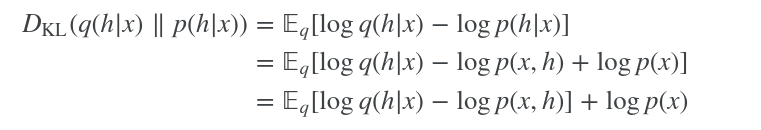



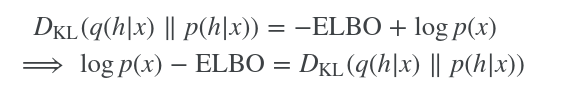

Now we may use the image made earlier moving forward. Run the following cell to resize the image to 256x256 so it's easier to work with. If you haven't made an image, we will download the original Starry Night Baobab example.

### Example of forward diffusion applied to an image

In [ ]:
# @title Resize or download (Run Cell)

if 'image' not in locals() or image is None:
    print("No image found, downloading the Baobab sunset example!\n")
    url = "https://i.ibb.co/D8yWtrp/baobab.png"
    image = Image.open(requests.get(url, stream=True).raw)

if image.size[0]>256:
    image = image.resize((256,256))

image

Let us apply the function to the image and get a list of images at each time-step $t$.

First, we convert the image (an 8 bit integer array with RGB values ranging from 0 to 255) to a normalised image with values ranging from [-1, 1]


**Group task:** Why do we have to normalise the image from -1 to 1?

_hint: think about Gaussian distributions_

In [ ]:
x_0 = jnp.asarray(image, dtype=jnp.float32)[jnp.newaxis, ...]
x_0 = x_0 / 255.0  # normalize the images to [0, 1]
x_0 = (x_0 * 2.0) - 1.0  # convert range to [-1, 1]

key = jax.random.PRNGKey(0)

x_t = x_0
x_t_history = [x_t] # Save the first image

for t in range(1, T+1):
    noise = jax.random.normal(key, x_t.shape)
    x_t = q_sample_one_timestep(x_t, t, noise)
    x_t_history.append(x_t)

Great! Now we can visualise them. Below we display $\mathbf{x}_0$, $\mathbf{x}_3$, $\mathbf{x}_{10}$, $\mathbf{x}_{60}$, $\mathbf{x}_{100}$, and $\mathbf{x}_{200 = T}$ from left to right.

In [ ]:
# @title Diffusion evolution (Run Cell)
ts = [0, 3, 10, 60, 100, 200]

# TODO remove axis ticks

num_cols = len(ts)
fig, axs = plt.subplots(figsize=(50, 50), nrows=1, ncols=num_cols, squeeze=False)
for i, t in enumerate(ts):

    # rescale image back to range 0-255
    noisy_image = (x_t_history[t] + 1.0) / 2.0
    noisy_image = noisy_image * 255.0
    noisy_image = np.array(noisy_image).astype(jnp.uint8)[0]

    ax = axs[0, i]
    ax.imshow(noisy_image)
    ax.set_title(f"$t={t}$", fontsize=30)

    # Remove axis labels and ticks
    ax.axis('off')

plt.tight_layout()

And just like that we have the forward diffusion process down! We're able to take an image and iteratively add noise.

### Math behind forward diffusion continued (Optional)



We investigate the rationale behind maximizing the ELBO. By introducing latent variables, our objective becomes capturing the underlying latent structure that explains our observed data. In essence, we aim to align our estimated posterior distribution with the true posterior, minimizing their discrepancy (KL Divergence). However, directly optimizing this divergence is computationally infeasible due to the inaccessibility of the true posterior.

Interestingly, the ELBO and KL Divergence are intrinsically linked. Maximizing the ELBO is equivalent to minimizing the KL Divergence.

**How do we do it?**

Both VAEs and Diffusion models use Variational Inference.

In our case, we directly maximize the ELBO. This approach is variational because we optimize for the best $q_\phi(z \mid x)$ amongst a family of potential posterior distributions parameterized by $\phi$. It is called an autoencoder because it is reminiscent of a traditional autoencoder model, where input data is trained to predict itself after undergoing an intermediate bottlenecking representation step.

**Deep Learning Notation:**

Variational Inference (VI) is a technique used to approximate intractable posterior distributions. Consider a latent variable model where we observe data $x$ and want to infer the latent variable $z$. Mathematically, we're interested in the posterior distribution $p(z \mid x)$.


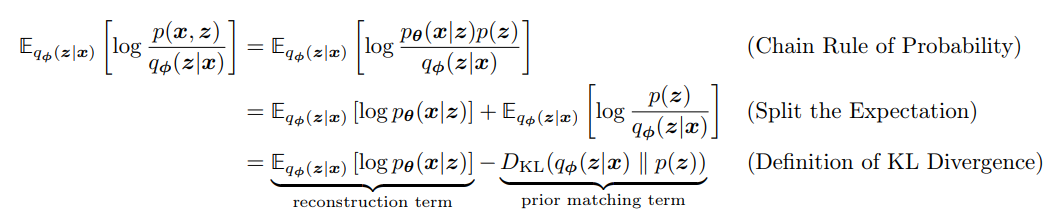

In this case, we learn an intermediate bottlenecking distribution $q_\phi(z \mid x)$ that can be treated as an encoder; it transforms inputs into a distribution over possible latents. Simultaneously, we learn a deterministic function $p_\theta(x \mid z)$ to convert a given latent vector $z$ into an observation $x$, which can be interpreted as a decoder.

In the last equation introduced:
* The first term measures the reconstruction likelihood of the decoder from our variational distribution—this ensures that the learned distribution is modeling effective latents that the original data can be regenerated from.
* The second term measures how similar the learned variational distribution is to a prior belief held over latent variables.


A defining feature of the VAE is how the ELBO is optimized jointly over parameters $\phi$ and $\theta$. The encoder of the VAE is commonly chosen to model a multivariate Gaussian with diagonal covariance, and the prior is often selected to be a standard multivariate Gaussian.

**Joint Optimization of $\phi$ and $\theta$**

A defining characteristic of VAEs is the simultaneous optimization of two sets of parameters:

- **$\phi$: Parameters of the encoder network.**
- **$\theta$: Parameters of the decoder network.**

This joint optimization is crucial for learning a meaningful latent space representation. The encoder maps input data to a latent space distribution, while the decoder generates data from samples drawn from this latent space. Both components are refined iteratively to maximize the ELBO.

**The ELBO as the Objective Function**

The Evidence Lower Bound (ELBO) is a lower bound on the marginal likelihood of the observed data. It serves as the objective function for training the VAE. By maximizing the ELBO, we aim to:

- Improve the encoder's ability to capture the underlying data distribution.
- Enhance the decoder's capability to reconstruct the original data from the latent space.

**Multivariate Gaussian Encoder**

The encoder in a VAE typically models the latent space as a multivariate Gaussian distribution. This means that the encoder outputs the parameters of a Gaussian distribution (mean and covariance matrix) for each input data point. By doing so, the VAE can capture complex relationships between latent variables and generate diverse outputs.

In summary, the VAE's strength lies in its ability to jointly optimize both the encoder and decoder through the maximization of the ELBO. The use of a multivariate Gaussian distribution for the encoder allows for a flexible representation of the latent space.

## 1.6 Reverse Diffusion

Now that we have the forward process down, what about the reverse diffusion process? Recall for reverse diffusion we want to remove noise from an image. Given some corrupted image at timestep $t$, and a target image $\mathbf{x}_0$, we want to iteratively move towards $\mathbf{x}_0$.

For images, we can define this **reverse** denoising distribution as a gaussian paramaterised as follows:

$$
q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0) = \mathscr{N}\left(\mathbf{x}_{t-1} ; \frac{1}{1-\bar{\alpha}_t}(\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\mathbf{x}_0), \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\mathbf{I}\right)
$$

That's a lot to take in! Lets break it up into a separate mean and covariance. Firstly, the mean is defined as:

$$
\mu_q(\mathbf{x}_t,\mathbf{x}_0) = \frac{1}{1-\bar{\alpha}_t}(\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})\mathbf{x}_t + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\mathbf{x}_0)
$$

While this may look complicated, it is essentially an interpolation between $\mathbf{x}_t$ and $\mathbf{x}_0$ with a bunch of normalising constants. The intuition is that for small values of $t$, $\bar{\alpha}_t$ will be large (close to 1). This results in the mean $\mu_q$ being closer to $\mathbf{x}_0$ for small values of $t$, and closer to $\mathbf{x}_t$ for large values of t. See [Luo C](https://arxiv.org/pdf/2208.11970.pdf) for the full derivation.

The covariance on the other hand is simply a function of $t$, and may be defined as:

$$
\Sigma_q(t) = \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\mathbf{I}
$$

For small values of $t$ the variance is low, but as $t \rightarrow T$, the variance approaches $1$.

### Math intro to reverse diffusion (Optional)

Similarly to the forward process, we have included a section here with some of the math behind the reverse process. This section is also optional if you want a deeper dive into the math!

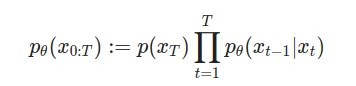

where:

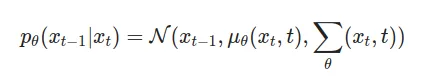

We can explain the above equation as follows: $p_\theta(x_{0:T})$ (diffusion process) is a chain of Gaussian transitions starting at $p(x_T)$ and iterating $T$ times using the equation for one diffusion process step $p_\theta(x_{t-1} \mid x_t)$.

What is important to know is that...


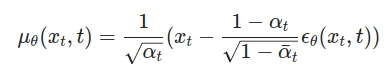

which give us:

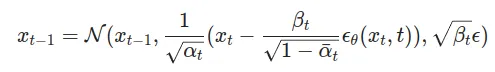

**Math Section:**

Let's delve into the math behind this:
$q(x_t \mid x_0)$ can be recursively derived through repeated applications of the reparameterization trick.

**What is the reparameterization trick?**

In Variational Autoencoders (VAEs), we aim to learn the parameters of an approximate posterior distribution, typically a Gaussian, $q(z \mid x)$. This distribution is used to sample latent variables $z$, which are then decoded to reconstruct the input $x$.

The challenge arises when trying to compute gradients with respect to the parameters of the encoder network, as sampling from a distribution is not a differentiable operation. This prevents the use of backpropagation, a cornerstone of neural network training.

**The Solution: Reparameterization**

The reparameterization trick offers a clever workaround. Instead of directly sampling from $q(z \mid x)$, we introduce an auxiliary random variable $\epsilon$, typically sampled from a standard normal distribution $\mathcal{N}(0, I)$.

The latent variable $z$ is then computed as:

                   z = µ + σ * ε

Where:
* $\mu$ and $\sigma$ are the mean and standard deviation of $q(z \mid x)$, respectively, outputted by the encoder network.
* $\epsilon$ is the sampled noise from the standard normal distribution.


Suppose that we have access to 2T random noise variables following a gaussian distribution then, bitrary sample xt ∼ q(xt|x0), we can rewrite:
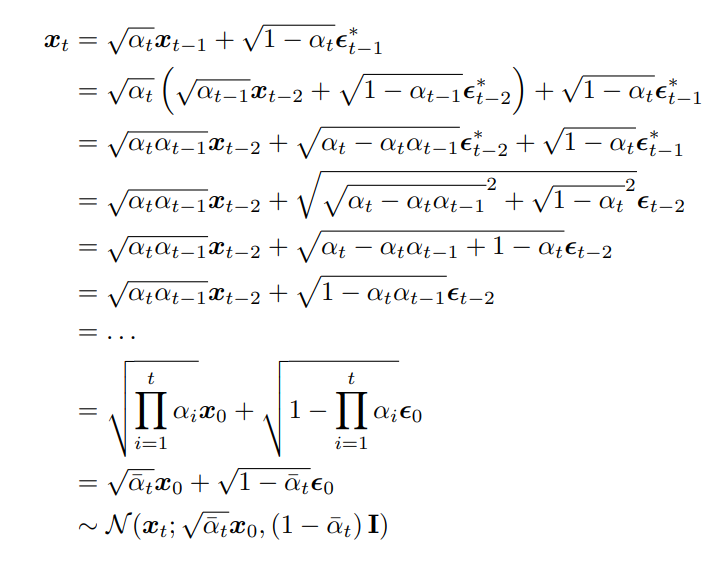


...where we have utilized the fact that the sum of two independent Gaussian random variables remains a Gaussian, with the mean being the sum of the two means, and the variance being the sum of the two variances. We then apply the reparameterization trick again.

We have therefore derived the Gaussian form of $q(x_t \mid x_0)$. This derivation can be modified to also yield the Gaussian parameterization describing $q(x_{t-1} \mid x_0)$. Now, knowing the forms of both $q(x_t \mid x_0)$ and $q(x_{t-1} \mid x_0)$, we can proceed to calculate the form of $q(x_{t-1} \mid x_t, x_0)$ by substituting into the Bayes' rule expansion:


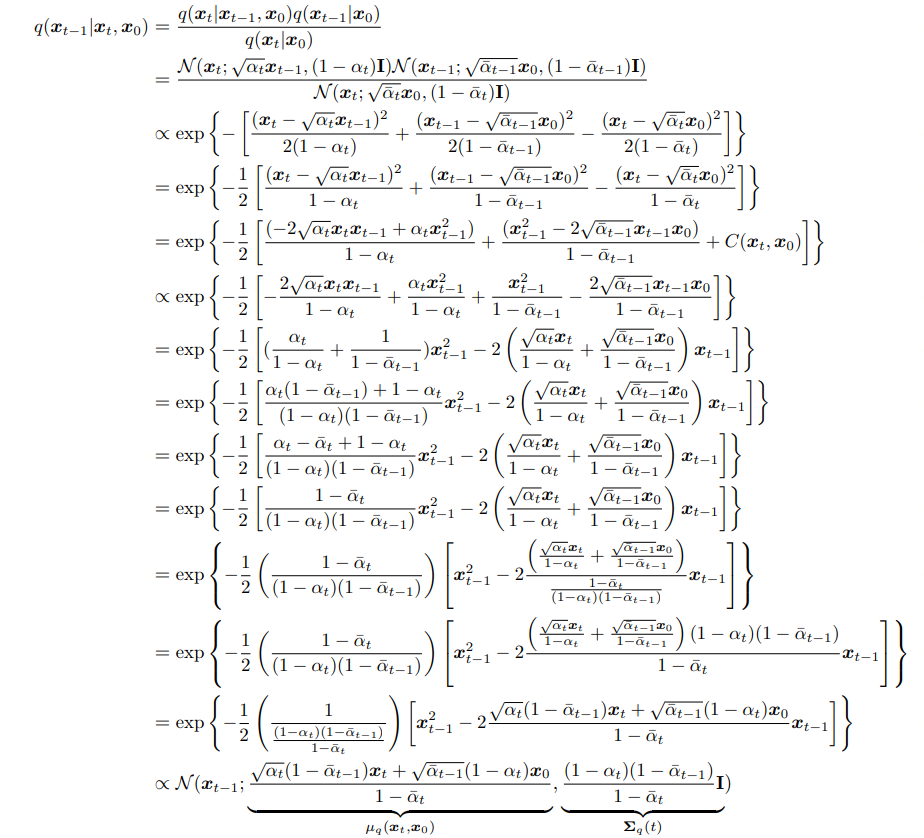

### Reverse diffusion in practice

In [ ]:
def mu_q(x_t, x_0, t):
    alpha_cumprod_t = extract(alphas_cumprod, t, x_t.shape)
    alpha_cumprod_tm1 = extract(alphas_cumprod, t-1, x_t.shape)
    alpha_t = extract(alphas, t, x_t.shape)

    return (1 / (1 - alpha_cumprod_t)) * (jnp.sqrt(alpha_t)*(1 - alpha_cumprod_tm1)*x_t + jnp.sqrt(alpha_cumprod_tm1)*(1 - alpha_t)*x_0)

def var_q(t, shape):
    alpha_cumprod_t = extract(alphas_cumprod, t, shape)
    alpha_cumprod_tm1 = extract(alphas_cumprod, t-1, shape)
    alpha_t = extract(alphas, t, shape)

    return (1 - alpha_t) * (1 - alpha_cumprod_tm1) / (1 - alpha_cumprod_t)

To help digest these equations, lets try visualie the distributions. In this example we will consider a single scalar value, where $x_0 = 0.5$ and $x_t = 0.1$. We can then plot the gaussian distributions.

In [ ]:
import seaborn as sns
key = jax.random.PRNGKey(0)

x_t = jnp.array([0.1])
x_0 = jnp.array([0.5])

# Add x_0 and x_t
# Try increase variance
ts = [10, 30, 100, 200]

cmap = sns.color_palette("coolwarm", n_colors=4)

for i,t in enumerate(ts):
    noise = jax.random.normal(key, (10000,))
    mean = mu_q(x_t, x_0, t)
    # We're multiplying by 2 here just to better visualise the distributions
    var = var_q(t, x_t.shape) * 2
    plt.hist(mean + noise * var , bins=20, density=True, color=cmap[i])

plt.xlabel("$x_t$", fontsize=20)
plt.ylabel("density", fontsize=14)
plt.legend([f"$t={t}$" for t in ts])
plt.grid()
plt.show()

## 1.7 Augmenting the reverse process with a model

Great! Now we know how to go both **forward** and **reverse**, but we have a problem. The reverse process is conditioned on $\mathbf{x}_0$, but what will $\mathbf{x}_0$ be in practice if we want to generate novel images? This is where the model comes in! We let the model make a prediction of $\mathbf{x}_0$, referred to as $\mathbf{\hat{x}}_0$, and then use the reverse process as normal.

Concretely, we can now write the distribution $p(\mathbf{x}_{t-1}|\mathbf{x}_t) $ parameterised by a model with weights $\theta$:

$$
p(\mathbf{x}_{t-1}|\mathbf{x}_t) = \mathscr{N}\left(\mathbf{x}_{t-1}; \frac{1}{1-\bar{\alpha}_t}(\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1}\mathbf{x}_t) + \sqrt{\bar{\alpha}_{t-1}}(1-\alpha_t)\hat{\mathbf{x}}_0), \frac{(1-\alpha_t)(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha_t}}\mathbf{I}\right)
$$

where the model predicts a disribution over $\mathbf{\hat{x}}_0$, and $\alpha_t$ is defined earlier in Section 1.4:

$$
p(\hat{\mathbf{x}}_0 | \mathbf{x}_t, \mathbf{c}) = \texttt{Model}(\mathbf{x}_t, \mathbf{c}, \theta)
$$

where $\mathbf{c}$ is an optional conditioning input and $\theta$ are the model parameters. For diffusion models like the one used in Section 1, $\mathbf{c}$ represents an encoding of the text conditioning. Most commonly, a frozen [CLIP](https://github.com/openai/CLIP) text encoder is used for this, as the text embeddings are quite rich and already trained to contain information relevant to images. Given a sequence of text, the CLIP text encoder outputs a fixed-dimensional embedding representing the content of the sequence.

_Note: While CLIP is the most common way to do conditioning, we won't be using it in the next section of the prac. This is due to the simplicity of the training task we will be considering, where a simple `nn.Embed` layer is sufficient. Feel free to augment the model with your own text embeddings, especially if you choose to use the Fashion MNIST dataset!_

We will now visualise both $p(\mathbf{x}_{t-1}|\mathbf{x}_t)$ and $q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)$. Previously, we let $\mathbf{x}_t$ be a scalar. In this example we will let $\mathbf{x}_t$ have two dimensions. In this example we arbitrarily choose:
- $\mathbf{x}_0 = [-0.6, -0.5]$
- $\hat{\mathbf{x}}_0 = [-0.7, 0.1]$
- $\mathbf{x}_t = [0.6, 0.5]$

In [ ]:
# @title Visualise distributions as a function of $t$ (Run Cell) {run: "auto"}

import matplotlib
import numpy as np
from matplotlib.lines import Line2D


x_0 = [-6/10.,-5./10]
x_0_hat = [-7./10, 1./10]
x_t = [6./10,5./10]

t = 50 #@param {type:"slider", min:0, max:200, step:5}

plt.clf()
plt.figure(figsize=(9,6))
ax = plt.gca()
ax.clear()


plt.plot([x_t[0], x_0[0]], [x_t[1], x_0[1]], linestyle='dashed', color='blue', alpha=0.5)
plt.plot([x_t[0], x_0_hat[0]], [x_t[1], x_0_hat[1]], linestyle='dashed', color='red', alpha=0.5)

plt.scatter(x_0[0], x_0[1], c='black')
plt.scatter(x_0_hat[0], x_0_hat[1], c='black')
plt.scatter(x_t[0], x_t[1], c='black')

delta = 0.005
x = np.arange(-1.0, 1.0, delta)
y = np.arange(-.75, .75, delta)
X, Y = np.meshgrid(x, y)


if t > 0:
    mean = mu_q(jnp.array(x_t), jnp.array(x_0), jnp.array([t,t]))
    # We're multiplying by 2 here just to better visualise the distributions
    var = var_q(jnp.array([t]), (1,))[0]*5
    Z = bivariate_normal(X, Y, var, var, mean[0], mean[1])
    CS = plt.contour(X, Y, Z, [Z.max()*(1-.95)], colors = 'blue', alpha=1, linestyles="solid")

    mean = mu_q(jnp.array(x_t), jnp.array(x_0_hat), jnp.array([t,t]))
    # We're multiplying by 2 here just to better visualise the distributions
    var = var_q(jnp.array([t]), (1,))[0]*5
    Z = bivariate_normal(X, Y, var, var, mean[0], mean[1])
    CS = plt.contour(X, Y, Z, [Z.max()*(1-.95)], colors = 'red', alpha=1, linestyles="solid")
else:

    plt.scatter(x_0[0], x_0[1], c='blue', s=2)
    plt.scatter(x_0_hat[0], x_0_hat[1], c='red', s=2)

ax.annotate("$\mathbf{x}_0$", (x_0[0]-0.2/10, x_0[1]-1.2/10), fontsize=16)
ax.annotate("$\hat{\mathbf{x}}_0$", (x_0_hat[0]-0.2/10, x_0_hat[1]-1.2/10), fontsize=16)
ax.annotate("$\mathbf{x}_t$", (x_t[0]-0.2/10, x_t[1]-1.2/10), fontsize=16)

legend_elements = [Line2D([0], [0], color='blue', label='$q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0)$'),
                   Line2D([0], [0], color='red', label='$p(\mathbf{x}_{t-1} | \mathbf{x}_t)$')]

ax.legend(handles=legend_elements, loc='lower right', fontsize=16)


plt.xlabel("$x_0$", fontsize=16)
plt.ylabel("$x_1$", fontsize=16);

The shape of the distributions is shown by the red and blue circles, where the radius gives an indication of the variance. Notice how when $t$ decreases, the radius of the variance decreases, and the mean shifts linearly (along the dashed lines) towards each respective ${\mathbf{x}}_0$. When $t=T=200$, the variance is at a maximum.

**Group task:**
- Why is the distribution a circle? (i.e. equal variance in both dimensions)

# 2. Training and Sampling (generating images)

## 2.1. Putting it all together

Now that we have all the parts, let us put them together to make our own diffusion model! First off, lets start by looking at the training loop.

### Training

The training goes as follows:
- In each **batch**, we sample $\mathbf{c}$, $\mathbf{x}_0$ and $t$
  - $t$ is a randomly sampled integer ranging from 0 to $T$ for each batch item.
- We sample $\mathbf{x}_t \sim q(\mathbf{x}_t | \mathbf{x}_0)$
- The model predicts $\hat{\mathbf{x}}_0 \sim p(\hat{\mathbf{x}}_0 | \mathbf{x}_t, \mathbf{c}) = \texttt{Model}(\mathbf{x}_t, \mathbf{c}, \theta)$
- Compute the loss and update the weights $\theta$

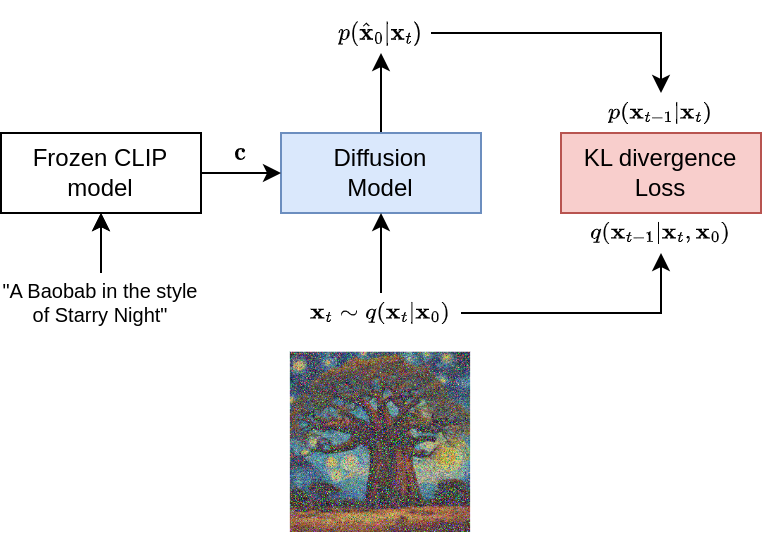

In general, as a loss function we compute the KL-divergence (a metric for comparing the similarity of two distributions) between the ground truth reverse distribution $q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)$ and the model's predicted distribution $p(\mathbf{x}_{t-1}|\mathbf{x}_t)$:

$$
\mathcal{L} = \text{KL}(q(\mathbf{x}_{t-1}|\mathbf{x}_t, \mathbf{x}_0)\ ||\ p(\mathbf{x}_{t-1}|\mathbf{x}_t))
$$

To make sense of this loss function, look at the distribution visualisation of the previous section. The KL-divergence is comparing the distribution of the red circle to the distribution of the blue circle!

The training loop may come across as strange. Why do we sample a random value for $t$ and not iterate from $T$ to $0$? What if we gave the model random noise and told it to iteratively denoise it with the target image? Theoretically we could do this, but it would likely cause a lot more overfitting, or it may not even learn at all! If we show the image only one sample of the same image per batch, it helps prevent overfitting. Also, if we give the model an image that is only _slightly noised_, it would stabalise training as the task is relatively easy for low values of $t$. Maybe this is also why Diffusion models perform so well? Discuss it amongst your neighbours!

### Generation and sampling

The process of generating novel images is relatively straightforward. We simply start with some random sample $\mathbf{x}_T \sim \mathscr{N}(\mathbf{x}_T ; \mathbf 0, \mathbf I)$ and iteratively decode until we reach $\mathbf x_0$

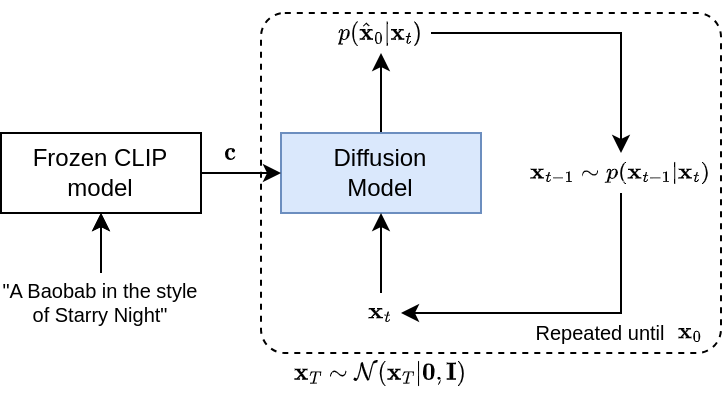

This is quite different to how the model is trained. This time we start from random noise and iterate $t$ from $T$ to $0$. Why does this work when this is not how the model is trained? If the model has been sufficiently trained (for long enough), it should have seen the same types of images for all values of $t$, so it shouldn't be an issue! Once again, discuss it amongst your neighbours!

## 2.2 Diffusion in one dimension

Rather than using a diffusion model to learn something complicated and high-dimensional, like the distribution of image pixels, we will try learn a 1-dimensional distribution first: two normal distributions with different means added together. Lets call this distribution $q(x)$:

In [ ]:
np.random.seed(0)

NUM_SAMPLES: int = 1200
NUM_NOISE_STEPS: int = 300
MEAN_1: float = -4.
MEAN_2: float = 2.0
samples_1 = np.random.normal(size=NUM_SAMPLES // 2, loc=MEAN_1)
samples_2 = np.random.normal(size=NUM_SAMPLES // 2, loc=MEAN_2)
q_samples = np.concatenate((samples_1, samples_2))

plt.grid(axis='y')
seaborn.histplot(q_samples, bins=30, kde=True, zorder=2);

**Key observation**: for any possible distribution $q(x)$, if we add small amounts of Gaussian noise enough times, we end up with a Gaussian distribution! Let us see this in action with our $q(x)$:

In [ ]:
BETA = 0.02

def add_noise_to_samples(data: np.ndarray, num_steps: int) -> np.ndarray:
  data_saved = [data]
  for step in range(num_steps):
    mean = data * np.sqrt(1 - BETA)
    # We use constant noise, but there are many more complicated choices.
    # See https://sander.ai/2024/06/14/noise-schedules.html
    stddev = np.sqrt(BETA)
    data = np.random.normal(size=len(data), loc=mean, scale=stddev)
    data_saved.append(data)
  return data_saved

# distribution_samples_noise is a list of length NUM_NOISE_STEPS, each element
# of the list is a NumPy array of length NUM_NOISE_STEPS.
q_samples_noised = add_noise_to_samples(q_samples, num_steps=NUM_NOISE_STEPS)
# plot the probability density of the most noised sample
seaborn.histplot(q_samples_noised[-1], bins=30, kde=True, stat='probability')

We can animate this process:

In [ ]:
# @title Animate diffusion (Run Cell)

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

def update(t):
    ax.clear()
    seaborn.histplot(q_samples_noised[t].flatten(), bins=np.arange(-8, 5, 0.25), kde=True, ax=ax);
    ax.set_xlim(-8, 5)  # Adjust limits as needed
    ax.set_title(f't = {t}')
    plt.close()

ani = FuncAnimation(fig, update, frames=range(0, NUM_NOISE_STEPS + 1, 10), repeat=False)

# Save the animation as HTML5 video
html_video = ani.to_html5_video()
HTML(html_video)

Which is approximately Gaussian with mean 0 and standard deviation of 1 (i.e. a standard normal distribution):

**Group Task:** Can you explain why this happens?

In [ ]:
print('mean: ', np.mean(q_samples_noised[-1]))
print('std_dev: ', np.std(q_samples_noised[-1]))

## 2.3 Training a model

**Now comes the magic**: what if we could train a model learns to undo the noise we added at each step? Then we can take samples from a simple normal distribution $\mathscr{N}(0,1)$, apply this denoising model many times to turn a sample from $\mathscr{N}(0,1)$ into a sample from our original distribution $q(x)$! The denoising task is a simple regression task: we have a list of samples `q_samples_noised` whose length is the number of noise steps (`NUM_NOISE_STEPS`). We want to predict `q_samples_noised[i-1]` given `q_samples_noised[i]` (the feature). This is a simple supervised learning problem! (regression)

However, we have one more feature our model might find useful: the time step! It will be useful to have all timesteps be between 0 and 1 (so each timestep is of size `1/NUM_NOISE_STEPS`). The reason for this will become clear when we want to generate samples later.

To recap: we have a supervised learning problem with input features `(q_samples_noised[i], i/NUM_NOISE_STEPS)` and predicted value `q_samples_noised[i]`. Make the training data:

In [ ]:
def make_training_data(data: list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:
  data_concat = np.stack(data)

  assert data_concat.shape == (NUM_NOISE_STEPS + 1, NUM_SAMPLES)

  y_vals = data_concat[:-1].flatten()
  x_vals = data_concat[1:]

  num_noise_steps, num_samples = x_vals.shape

  time_steps = np.linspace(0, 1, num_noise_steps)
  time_steps = np.broadcast_to(time_steps.reshape((num_noise_steps, -1)), x_vals.shape)
  x_vals = np.stack((x_vals.flatten(), time_steps.flatten()), axis=-1)

  assert len(y_vals) == len(x_vals)

  return x_vals, y_vals


x_vals, y_vals = make_training_data(q_samples_noised)

**Task**: Discuss what the shape of `x_vals` and `y_vals`. Why are there 360000 examples? Hint: what is this in terms of `NUM_NOISE_STEPS` and `NUM_SAMPLES`?

In [ ]:
print('x_vals shape', x_vals.shape)
print('y_vals shape', y_vals.shape)

We can pick our favourite regression algorithm here. We will use a simple multi-layer perceptron (MLP) via Scikit-learn (could also use JAX but this is simpler).

**Task**: what would happen if we used [linear regression](https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares) instead? Would this work?

In [ ]:
from sklearn.neural_network import MLPRegressor

reverse_model = MLPRegressor(hidden_layer_sizes=(4, 4),
                    activation='tanh',
                    solver='lbfgs',
                    early_stopping=True)

reverse_model.fit(x_vals, y_vals)

We have a trained diffusion model! Now we want to produce some samples with it and see whether these are similar to our original distribution.

**Key result for sampling**: if our time steps were small enough, then each reverse distribution $q(x_{t-1} | x_t)$ is approximaly Gaussian, and our learnt model `reverse_model` predicts the mean of this distribution.
- This is not an obvious fact. For those interested in an explanation and proof of this fact, see Section 2 of https://arxiv.org/abs/2406.08929.


In [ ]:
def generate(model, num_samples: int, num_steps:int) -> np.ndarray:
  samples = np.random.normal(size=num_samples, loc=0, scale=1.)
  samples_history = [samples]
  for t in range(num_steps, 0, -1):
    # Make sure all time_steps are between 0 and 1, like for training.
    time_steps = np.repeat(t/num_steps, repeats=num_samples)
    x_val = jnp.stack((samples, time_steps), axis=-1)
    # Our learnt model predicts the mean of the Gaussian.
    mean = model.predict(x_val)
    # Key fact: reverse distribution is a Gaussian!
    samples = mean + np.random.normal(size=num_samples, loc=0, scale=np.sqrt(BETA))
    samples_history.append(samples)
  return samples, samples_history

samples, samples_history = generate(reverse_model, num_samples=1000, num_steps=500)

seaborn.histplot(samples.flatten(), bins=np.arange(-8, 5, 0.25), kde=True)

We can automatically extract the means by fitting a Gaussian Mixture model

In [ ]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(samples.reshape(-1, 1))
print('learnt distribution means: ', gm.means_[1, 0], gm.means_[0, 0])
print('original means: ', MEAN_2, MEAN_1)

Pretty close!

**Task**: play with `num_steps` in the `generate` call above. How might we decide what a good number of `num_steps` should be? Does it have to be what we trained with, `NUM_NOISE_STEPS = 300`? Can you now explain why we normalized the time steps to be between 0 and 1? (**Hint**: might there be problems with our model during generation if we just used integers up to `NUM_NOISE_STEPS` during training?)

Before we end off, let us also visualise the the samples at each timestep:

In [ ]:
# @title Visualise distribution at timestep $t$ (Run Cell) {run: "auto"}

t = 175 #@param {type:"slider", min:0, max:500, step:5}

seaborn.histplot(samples_history[t].flatten(), bins=np.arange(-8, 5, 0.25), kde=True)
plt.title(f"t={t}")

We can even animate the generation!

In [ ]:
# @title Animate diffusion (Run Cell)

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

fig, ax = plt.subplots()

def update(t):
    ax.clear()
    seaborn.histplot(samples_history[t].flatten(), bins=np.arange(-8, 5, 0.25), kde=True, ax=ax);
    ax.set_xlim(-8, 5)  # Adjust limits as needed
    ax.set_title(f't = {t}')
    plt.close()

ani = FuncAnimation(fig, update, frames=range(0, len(samples_history), 10), repeat=False)

# Save the animation as HTML5 video
html_video = ani.to_html5_video()
HTML(html_video)

# Conclusion
**Summary:**

In this practical, we took a look at an exciting new variant of generative modelling: diffusion. We explored the two processes used to train and generate with these models, the forward noising process and the reverse denoising process.

**Next Steps:**

As next steps, we encourage you to look at last year's prac where we go through a similar process but give details more details on the specifics on running these models with images.
- https://github.com/deep-learning-indaba/indaba-pracs-2023/blob/main/practicals/diffusion_models.ipynb
- In this practical, we train a U-Net model to generate MNIST digits!

If you would like a more in-depth look at the probablisitc theory, we encourage you to go through the 2022 deep generative models practical by **James Allingham**:
- https://github.com/deep-learning-indaba/indaba-pracs-2022/blob/main/practicals/deep_generative_models.ipynb
- This practical takes a deep dive into the probabilistic theory behind diffusion and includes a practical implementation in Jax and Haiku


<!-- **Appendix:**

[Anything (probably math heavy stuff) we don't have space for in the main practical sections.] -->

**References:**

- Understanding Diffusion Models: A Unified Perspective; Luo C. \
https://arxiv.org/pdf/2208.11970.pdf

- Denoising Diffusion Probabilistic Models; Ho, J., Jain, A., Abbeel, Pieter. \
https://arxiv.org/abs/2006.11239

- Step-by-Step Diffusion: An Elementary Tutorial; Nakkiran, P., Bradley, A., Zhou, H., Advani, M. \
https://arxiv.org/abs/2406.08929


For other practicals from the Deep Learning Indaba, please visit [here](https://github.com/deep-learning-indaba/indaba-pracs-2024).

## Feedback

Please provide feedback that we can use to improve our practicals in the future.

In [ ]:
# @title Generate Feedback Form. (Run Cell)
from IPython.display import HTML

HTML(
    """
<iframe
	src="https://forms.gle/Cg9aoa7czoZCYqxF7",
  width="80%"
	height="1200px" >
	Loading...
</iframe>
"""
)

<img src="https://baobab.deeplearningindaba.com/static/media/indaba-logo-dark.d5a6196d.png" width="50%" />